In [1]:
library(ggplot2)
library(reshape2)
library(scater)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [3]:
allelic_F1 <- readRDS("/Users/z5345125/repos/ASPEN-GLM/data/aspensce_sexupdated_F1.rds")

In [4]:
# Subset columns (cells), not rows
keep_cols <- !is.na(allelic_F1$sex) & allelic_F1$sex != "Ambiguous" &
             !is.na(allelic_F1$condition_new) & allelic_F1$condition_new != "Ambiguous"

allelic_F1_filtered <- allelic_F1[, keep_cols]

allelic_F1_filtered

class: SingleCellExperiment 
dim: 15653 8522 
metadata(0):
assays(3): a1 a2 tot
rownames(15653): 0610005C13Rik 0610009E02Rik ... Zfp41 Zfp931
rowData names(0):
colnames(8522): Sample_1_AAACAGCCACCGGCTA Sample_1_AAACAGCCAGGATGGC ...
  Sample_8_repeat_TTTGTGTTCAAAGGCA Sample_8_repeat_TTTGTTGGTGTTGTAG
colData names(11): orig.ident sex ... counts_total_RNA
  genes_detected_RNA
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [5]:
allelic_F1_filtered

class: SingleCellExperiment 
dim: 15653 8522 
metadata(0):
assays(3): a1 a2 tot
rownames(15653): 0610005C13Rik 0610009E02Rik ... Zfp41 Zfp931
rowData names(0):
colnames(8522): Sample_1_AAACAGCCACCGGCTA Sample_1_AAACAGCCAGGATGGC ...
  Sample_8_repeat_TTTGTGTTCAAAGGCA Sample_8_repeat_TTTGTTGGTGTTGTAG
colData names(11): orig.ident sex ... counts_total_RNA
  genes_detected_RNA
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [6]:
saveRDS(allelic_F1_filtered, file = "/Users/z5345125/repos/ASPEN-GLM/data/aspensce_sexupdated_F1_filtered.rds")

### Analysis for different celltypes

In [25]:
## Load libraries

suppressPackageStartupMessages({
    if (requireNamespace("ASPEN", quietly = TRUE)) {
        library(ASPEN)
    } else {
        message("ASPEN not installed; sourcing all R/ functions …")
        rfiles <- list.files("../R", full.names = TRUE, pattern = "\\.R$")
        print(rfiles)
        invisible(lapply(rfiles, source))
    }
    library(ggplot2)
    library(ggpointdensity)
    library(gridExtra)
})


ASPEN not installed; sourcing all R/ functions …



[1] "../R/allelic_imbalance.R"    "../R/allelic_variation.R"   
[3] "../R/diagnostics.R"          "../R/diffASE.R"             
[5] "../R/estim_glmparams.R"      "../R/parameter_estimation.R"
[7] "../R/pipeline.R"             "../R/utils.R"               
[9] "../R/validation_helpers.R"  


In [26]:
list_group_dirs <- function(base_dir = "../results/celltype_wo_condition") {
  ct_dirs <- dir(base_dir, full.names = TRUE)
  if (!length(ct_dirs)) return(data.frame(path = character(), celltype = character(), condition = character(), stringsAsFactors = FALSE))
  ct_dirs <- ct_dirs[file.info(ct_dirs)$isdir]
  groups <- lapply(ct_dirs, function(ct_dir) {
    cond_dirs <- dir(ct_dir, full.names = TRUE)
    cond_dirs <- cond_dirs[file.info(cond_dirs)$isdir]
    if (!length(cond_dirs)) return(NULL)
    data.frame(
      path = cond_dirs,
      celltype = basename(ct_dir),
      condition = basename(cond_dirs),
      stringsAsFactors = FALSE
    )
  })
  groups <- Filter(Negate(is.null), groups)
  if (!length(groups)) return(data.frame(path = character(), celltype = character(), condition = character(), stringsAsFactors = FALSE))
  out <- do.call(rbind, groups)
  out$group_id <- paste(out$celltype, out$condition, sep = "__")
  rownames(out) <- out$group_id
  out
}

group_info <- list_group_dirs()
print(group_info)

group_map <- setNames(group_info$path, group_info$group_id)


                                                                             path
Cardiomyocyte__F1_Aged     ../results/celltype_wo_condition/Cardiomyocyte/F1_Aged
Cardiomyocyte__F1_Young   ../results/celltype_wo_condition/Cardiomyocyte/F1_Young
Coronary_EC__F1_Aged         ../results/celltype_wo_condition/Coronary_EC/F1_Aged
Coronary_EC__F1_Young       ../results/celltype_wo_condition/Coronary_EC/F1_Young
Endocardial_EC__F1_Aged   ../results/celltype_wo_condition/Endocardial_EC/F1_Aged
Endocardial_EC__F1_Young ../results/celltype_wo_condition/Endocardial_EC/F1_Young
Fibroblast__F1_Aged           ../results/celltype_wo_condition/Fibroblast/F1_Aged
Fibroblast__F1_Young         ../results/celltype_wo_condition/Fibroblast/F1_Young
M2__F1_Aged                           ../results/celltype_wo_condition/M2/F1_Aged
M2__F1_Young                         ../results/celltype_wo_condition/M2/F1_Young
MacFib__F1_Aged                   ../results/celltype_wo_condition/MacFib/F1_Aged
MacFib__F1_Young

In [27]:
group_mode <- "condition"  # options: "sex" or "global"
base_dir <- file.path("../results", "celltype_wo_condition")

summarise_group <- function(path, alpha = 0.05) {
  out <- list(
    n_rows_bb_mean = NA_integer_,
    n_rows_group_mean = NA_integer_,
    n_rows_group_var = NA_integer_,
    sig_FDR_bb_mean = NA_integer_,
    sig_FDR_group_mean = NA_integer_,
    sig_FDR_group_var = NA_integer_
  )
  bb_path <- file.path(path, "bb_mean_results.csv")
  if (file.exists(bb_path)) {
    df <- read.csv(bb_path, row.names = 1)
    out$n_rows_bb_mean <- nrow(df)
    if (nrow(df)) {
      p_adj <- p.adjust(df$pval_mean, method = "fdr")
      out$sig_FDR_bb_mean <- sum(is.finite(p_adj) & p_adj < alpha, na.rm = TRUE)
    }
  }
  gm_path <- file.path(path, "group_mean_sex_results.csv")
  if (file.exists(gm_path)) {
    df <- read.csv(gm_path, row.names = 1)
    out$n_rows_group_mean <- nrow(df)
    if (nrow(df)) {
      p_adj <- p.adjust(df$pval, method = "fdr")
      out$sig_FDR_group_mean <- sum(is.finite(p_adj) & p_adj < alpha, na.rm = TRUE)
    }
  }
  gv_path <- file.path(path, "group_var_sex_results.csv")
  if (file.exists(gv_path)) {
    df <- read.csv(gv_path, row.names = 1)
    out$n_rows_group_var <- nrow(df)
    if (nrow(df)) {
      p_adj <- p.adjust(df$pval_var, method = "fdr")
      out$sig_FDR_group_var <- sum(is.finite(p_adj) & p_adj < alpha, na.rm = TRUE)
    }
  }
  as.data.frame(out)
}

if (!nrow(group_info)) {
  message("No cell type/condition groups found under ", normalizePath(base_dir, mustWork = FALSE))
} else {
  summary_list <- vector("list", nrow(group_info))
  for (i in seq_len(nrow(group_info))) {
    grp_path <- group_info$path[i]
    grp_id   <- group_info$group_id[i]
    message("\nRendering panels for: ", grp_id, " (mode = ", group_mode, ")")
    try(render_ct_panels(grp_path, group_names = NULL, midpoint = 500, save_png = TRUE, mode = group_mode), silent = TRUE)
    tmp <- summarise_group(grp_path, alpha = 0.05)
    tmp$group_id  <- grp_id
    tmp$celltype  <- group_info$celltype[i]
    tmp$condition <- group_info$condition[i]
    summary_list[[i]] <- tmp
  }
  summary_df <- do.call(rbind, summary_list)
  out_csv <- file.path(base_dir, paste0("celltype_condition_summary_FDR0.05_", group_mode, ".csv"))
  write.csv(summary_df, out_csv, row.names = FALSE)
  message("Saved: ", out_csv)
  print(summary_df)
}



Rendering panels for: Cardiomyocyte__F1_Aged (mode = condition)


Rendering panels for: Cardiomyocyte__F1_Young (mode = condition)


Rendering panels for: Coronary_EC__F1_Aged (mode = condition)


Rendering panels for: Coronary_EC__F1_Young (mode = condition)


Rendering panels for: Endocardial_EC__F1_Aged (mode = condition)


Rendering panels for: Endocardial_EC__F1_Young (mode = condition)


Rendering panels for: Fibroblast__F1_Aged (mode = condition)


Rendering panels for: Fibroblast__F1_Young (mode = condition)


Rendering panels for: M2__F1_Aged (mode = condition)


Rendering panels for: M2__F1_Young (mode = condition)


Rendering panels for: MacFib__F1_Aged (mode = condition)


Rendering panels for: MacFib__F1_Young (mode = condition)


Rendering panels for: Mesothelial__F1_Aged (mode = condition)


Rendering panels for: Mesothelial__F1_Young (mode = condition)


Rendering panels for: Myeloid__F1_Aged (mode = condition)


Rendering panels for: Myeloid__F1_Young (mode = conditio

   n_rows_bb_mean n_rows_group_mean n_rows_group_var sig_FDR_bb_mean
1            6723              6723             6723            2626
2            6415              6415             6415            2437
3            1986              1986             1986              88
4            1793              1793             1793              77
5            2842              2842             2842              84
6            2119              2119             2119              63
7            4468              4468             4468             397
8            3308              3308             3308             238
9            1227              1227             1227              68
10           1152              1152             1152              52
11           2730              2730             2730              81
12           1643              1643             1643              39
13           1176              1176             1176              46
14           1383              138

## Show the GLM quality results for different cell types

In [28]:
suppressPackageStartupMessages({
ok_aspen <- requireNamespace("ASPEN", quietly = TRUE)
if (ok_aspen) {
library(ASPEN)
} else {
message("ASPEN not installed; sourcing R/ …")
rfiles <- list.files("../R", full.names = TRUE, pattern = "\\.R$")
invisible(lapply(rfiles, source))
}
library(SingleCellExperiment)
library(Matrix)
})

# Paths
sce_path <- "../data/aspensce_sexupdated_F1_filtered.rds" # change if needed
base_dir <- "../results/celltype_wo_condition"

# Helpers
.pick_ct_col <- function(meta) {
for (nm in c("celltype_new","celltype","celltype_old")) if (!is.null(meta[[nm]])) return(nm)
stop("No celltype column found (celltype_new/celltype/celltype_old)")
}
.parse_thresholds <- function(log_path,
                              defaults = list(
                                min_counts_est = 0L,
                                min_cells_est = 5L,
                                min_counts_test = 0L,
                                min_cells_test = 5L,
                                min_counts_glob = 5L)) {
  vals <- defaults
  if (file.exists(log_path)) {
    ln <- readLines(log_path, warn = FALSE)
    hits <- regmatches(ln, gregexpr("min_[a-z_]+=[0-9]+", ln))
    if (length(hits)) {
      kv <- unique(unlist(hits))
      for (item in kv) {
        parts <- strsplit(item, "=", fixed = TRUE)[[1]]
        key <- parts[1]
        val <- suppressWarnings(as.integer(parts[2]))
        if (!is.na(val) && key %in% names(vals)) vals[[key]] <- val
      }
    }
  }
  vals
}

fit_one_gene <- function(y, n, design) {
df <- as.data.frame(design); df$resp <- y / n
fit <- tryCatch(glm(resp ~ ., family = quasibinomial(), weights = n, data = df,
control = glm.control(maxit = 100)),
error = function(e) NULL)
fit
}

# Extract per-gene coefficients for terms of interest (sex*)
coef_rows_for_terms <- function(fit, terms_regex = c("^sex")) {
if (is.null(fit)) return(NULL)
cf <- tryCatch(summary(fit)$coefficients, error = function(e) NULL)
if (is.null(cf)) return(NULL)
rn <- rownames(cf)
out <- list()
for (rgx in terms_regex) {
idx <- grep(rgx, rn)
if (length(idx) == 0) next
for (j in idx) {
out[[length(out)+1]] <- data.frame(
term = rn[j],
estimate = cf[j,1],
se = cf[j,2],
z = cf[j,3],
p = cf[j,4],
stringsAsFactors = FALSE
)
}
}
if (length(out) == 0) return(NULL)
do.call(rbind, out)
}

analyze_group <- function(grp_path, sce, meta, ct_col, sex_all, cond_all) {
ct <- basename(dirname(grp_path))
cond_label <- basename(grp_path)
grp_id <- paste(ct, cond_label, sep = "__")

est_path <- file.path(grp_path, "estimates_global_shrunk.rds")
if (!file.exists(est_path)) { message("No estimates for ", grp_id); return(NULL) }
est <- readRDS(est_path)
genes <- rownames(est)

cells_ct <- which(as.character(meta[[ct_col]]) == ct & cond_all == cond_label & sex_all %in% c("F","M"))
if (length(cells_ct) < 5) { message("Too few cells for ", grp_id); return(NULL) }

a1s <- SummarizedExperiment::assay(sce, "a1")[, cells_ct, drop = FALSE]
tots <- SummarizedExperiment::assay(sce, "tot")[, cells_ct, drop = FALSE]
genes_in <- intersect(genes, rownames(tots))
a1 <- as.matrix(a1s[genes_in, , drop = FALSE]); mode(a1) <- "integer"
tot <- as.matrix(tots[genes_in, , drop = FALSE]); mode(tot) <- "integer"

# Build design: sex only
sex <- factor(sex_all[cells_ct], levels = c("F","M"))
design_df <- data.frame(sex = sex)
rownames(design_df) <- colnames(tot)
design <- model.matrix(~ sex, data = design_df)

# thresholds from filter_log
thr <- .parse_thresholds(file.path(grp_path, "filter_log.txt"))
min_counts <- thr$min_counts_test; min_cells <- thr$min_cells_test

coef_list <- list()
fit_list <- list()
for (g in rownames(a1)) {
y <- as.numeric(a1[g, ]); n <- as.numeric(tot[g, ])
keep <- is.finite(y) & is.finite(n) & (n >= min_counts)
if (sum(keep) < min_cells) next
fit <- fit_one_gene(y[keep], n[keep], design[keep, , drop = FALSE])
if (is.null(fit)) next
fit_list[[g]] <- data.frame(
  gene = g,
  converged = isTRUE(fit$converged),
  iter = fit$iter,
  null_dev = fit$null.deviance,
  deviance = fit$deviance,
  df_null = fit$df.null,
  df_resid = fit$df.residual,
  r2_mcfadden = ifelse(is.finite(fit$null.deviance) && fit$null.deviance > 0, 1 - (fit$deviance / fit$null.deviance), NA_real_),
  stringsAsFactors = FALSE
)
cf <- coef_rows_for_terms(fit, terms_regex = c("^sex"))
if (!is.null(cf)) {
  cf$gene <- g
  coef_list[[g]] <- cf
}
}

coef_df <- if (length(coef_list) > 0) do.call(rbind, coef_list) else data.frame()
fit_df  <- if (length(fit_list) > 0) do.call(rbind, fit_list) else data.frame()
list(group_id = grp_id, coef_df = coef_df, fit_df = fit_df, path = grp_path)
}

# Run across groups and write outputs
sce <- readRDS(sce_path)
meta <- as.data.frame(colData(sce))
ct_col <- .pick_ct_col(meta)
sex_all <- as.character(meta$sex)
sex_all[sex_all %in% c("Female","F")] <- "F"
sex_all[sex_all %in% c("Male","M")] <- "M"
cond_all <- meta$condition_new
if (is.null(cond_all)) cond_all <- meta$condition_old
cond_all <- as.character(cond_all)
cond_all[is.na(cond_all) | cond_all == ""] <- "NA"

group_paths <- group_info$path
all_coef <- list(); all_fit <- list()
for (grp_path in group_paths) {
res <- analyze_group(grp_path, sce, meta, ct_col, sex_all, cond_all)
if (is.null(res)) next
if (nrow(res$coef_df) > 0) {
write.csv(res$coef_df, file.path(res$path, "glm_coef_by_gene.csv"), row.names = FALSE)
message("Saved coef table: ", file.path(res$path, "glm_coef_by_gene.csv"))
}
if (nrow(res$fit_df) > 0) {
write.csv(res$fit_df, file.path(res$path, "glm_model_fit_by_gene.csv"), row.names = FALSE)
message("Saved model fit table: ", file.path(res$path, "glm_model_fit_by_gene.csv"))
}
all_coef[[res$group_id]] <- res$coef_df
all_fit[[res$group_id]]  <- res$fit_df
}

# Aggregate quick summaries (percent significant per term; median R2)
summ_rows <- list()
for (gid in names(all_coef)) {
cf <- all_coef[[gid]]
mf <- all_fit[[gid]]
if (nrow(cf) == 0 || nrow(mf) == 0) next
sex_rows <- cf[grepl("^sex", cf$term), , drop = FALSE]
summ_rows[[gid]] <- data.frame(
celltype = group_info$celltype[group_info$group_id == gid],
condition = group_info$condition[group_info$group_id == gid],
group_id = gid,
n_genes_fit = length(unique(mf$gene)),
median_r2_mcfadden = median(mf$r2_mcfadden, na.rm = TRUE),
sex_terms = paste(unique(sex_rows$term), collapse = ";"),
pct_sig_sex = mean(sex_rows$p < 0.05, na.rm = TRUE),
stringsAsFactors = FALSE
)
}
summ_out <- if (length(summ_rows) > 0) do.call(rbind, summ_rows) else data.frame()
print(summ_out)
if (nrow(summ_out) > 0) {
out_csv <- file.path(base_dir, "aspen_sex_coef_significance_summary_groups.csv")
write.csv(summ_out, out_csv, row.names = FALSE)
message("Saved: ", out_csv)
}


ASPEN not installed; sourcing R/ …

Saved coef table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Aged/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Aged/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Young/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Cardiomyocyte/F1_Young/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Coronary_EC/F1_Aged/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Coronary_EC/F1_Aged/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Coronary_EC/F1_Young/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Coronary_EC/F1_Young/glm_model_fit_by_gene.csv

Saved coef table: ../results/celltype_wo_condition/Endocardial_EC/F1_Aged/glm_coef_by_gene.csv

Saved model fit table: ../results/celltype_wo_condition/Endocardial_EC/F

                               celltype condition                 group_id
Cardiomyocyte__F1_Aged    Cardiomyocyte   F1_Aged   Cardiomyocyte__F1_Aged
Cardiomyocyte__F1_Young   Cardiomyocyte  F1_Young  Cardiomyocyte__F1_Young
Coronary_EC__F1_Aged        Coronary_EC   F1_Aged     Coronary_EC__F1_Aged
Coronary_EC__F1_Young       Coronary_EC  F1_Young    Coronary_EC__F1_Young
Endocardial_EC__F1_Aged  Endocardial_EC   F1_Aged  Endocardial_EC__F1_Aged
Endocardial_EC__F1_Young Endocardial_EC  F1_Young Endocardial_EC__F1_Young
Fibroblast__F1_Aged          Fibroblast   F1_Aged      Fibroblast__F1_Aged
Fibroblast__F1_Young         Fibroblast  F1_Young     Fibroblast__F1_Young
M2__F1_Aged                          M2   F1_Aged              M2__F1_Aged
M2__F1_Young                         M2  F1_Young             M2__F1_Young
MacFib__F1_Aged                  MacFib   F1_Aged          MacFib__F1_Aged
MacFib__F1_Young                 MacFib  F1_Young         MacFib__F1_Young
Mesothelial__F1_Aged     

Saved: ../results/celltype_wo_condition/aspen_sex_coef_significance_summary_groups.csv



### Imbalance test (estimate the global mean first)

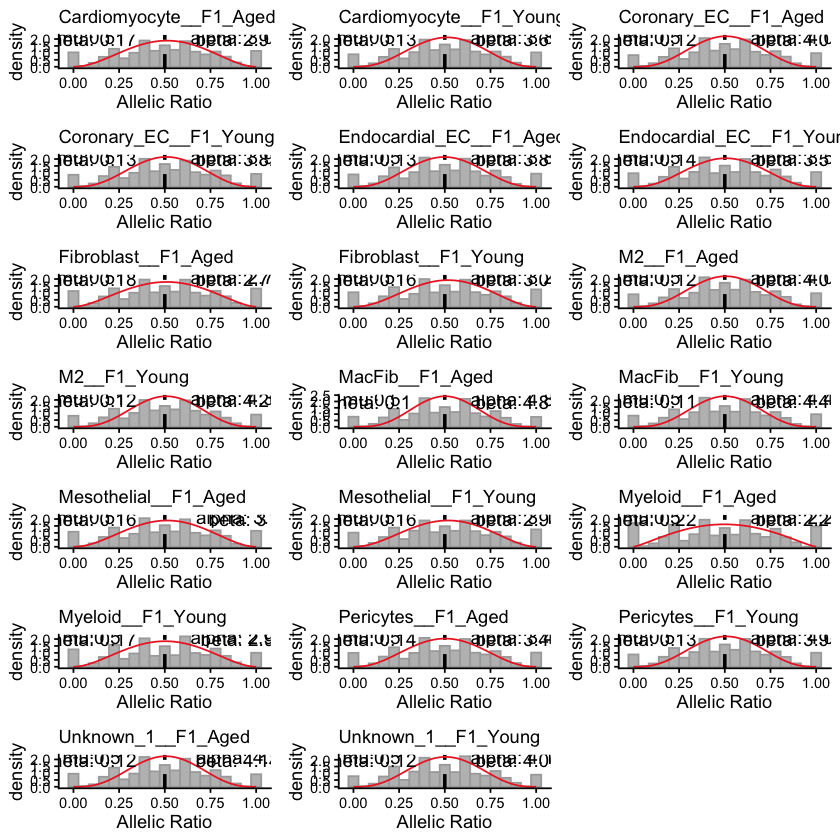

In [12]:
## assumes ASPEN functions are already available
library(gridExtra)
library(ggplot2)

sce_path <- "../data/aspensce_sexupdated_F1_filtered.rds"
glob_dir <- "../results/celltype_wo_condition"

sce  <- readRDS(sce_path)
meta <- as.data.frame(colData(sce))
ct_col <- intersect(c("celltype_new","celltype","celltype_old"), names(meta))[1]
stopifnot(!is.na(ct_col))

sex_all <- meta$sex
sex_all <- as.character(sex_all)
sex_all[sex_all %in% c("Female","F")] <- "F"
sex_all[sex_all %in% c("Male","M")]   <- "M"
cond_all <- meta$condition_new
if (is.null(cond_all)) cond_all <- meta$condition_old
cond_all <- as.character(cond_all)
cond_all[is.na(cond_all) | cond_all == ""] <- "NA"

load_gparams <- function(group_path) {
  f <- file.path(group_path, "global_params.csv")
  if (!file.exists(f)) return(NULL)
  df <- read.csv(f, row.names = 1, check.names = FALSE)
  vals <- df[1, c("mu","theta","alpha","beta")]
  as.numeric(vals)
}

plots <- list()
for (i in seq_len(nrow(group_info))) {
  grp_path <- group_info$path[i]
  grp_id   <- group_info$group_id[i]
  gparams <- load_gparams(grp_path)
  if (is.null(gparams) || any(!is.finite(gparams))) {
    message("No global_params.csv for ", grp_id, "; skipping.")
    next
  }

  cols <- which(meta[[ct_col]] == group_info$celltype[i] &
                 cond_all == group_info$condition[i] &
                 sex_all %in% c("F","M"))
  if (length(cols) < 5) {
    message("Too few cells for ", grp_id, "; skipping.")
    next
  }

  a1  <- as.matrix(assays(sce)[["a1"]][, cols, drop = FALSE]); mode(a1)  <- "integer"
  tot <- as.matrix(assays(sce)[["tot"]][, cols, drop = FALSE]); mode(tot) <- "integer"

  thr <- .parse_thresholds(file.path(grp_path, "filter_log.txt"))
  min_counts_glob <- if (!is.null(thr$min_counts_glob)) thr$min_counts_glob else 5L

  p <- plot_glob_params(a1, tot, gparams, min_counts = min_counts_glob) +
       ggplot2::labs(subtitle = grp_id)
  plots[[grp_id]] <- p
}

if (length(plots)) {
  gridExtra::grid.arrange(grobs = plots, ncol = 3)
} else {
  message("No panels to display (nothing matched).")
}


## normalised test results

## heat map for the top genes with the mean deviation from balance

In [21]:
results_fdr <- lapply(seq_len(nrow(group_info)), function(i) {
  grp_path <- group_info$path[i]
  f_rds <- file.path(grp_path, 'bb_mean_results_norm.csv')
  if (!file.exists(f_rds)) return(NULL)
  df <- tryCatch(read.csv(f_rds, row.names = 1, check.names = FALSE), error = function(e) NULL)
  if (!nrow(df)) return(NULL)
  if (is.null(rownames(df))) {
    df$gene <- NA_character_
  } else {
    df$gene <- rownames(df)
  }
  df$p.adj <- p.adjust(df$pval_mean, method = 'BH')
  df$group_id <- group_info$group_id[i]
  df$celltype <- group_info$celltype[i]
  df$condition <- group_info$condition[i]
  df
})
names(results_fdr) <- group_info$group_id
results_fdr <- Filter(Negate(is.null), results_fdr)


Cardiomyocyte__F1_Aged: 2555 genes with FDR < 0.05

Rendering top genes for Cardiomyocyte__F1_Aged

Cardiomyocyte__F1_Young: 2336 genes with FDR < 0.05

Rendering top genes for Cardiomyocyte__F1_Young

Coronary_EC__F1_Aged: 86 genes with FDR < 0.05

Rendering top genes for Coronary_EC__F1_Aged

Coronary_EC__F1_Young: 84 genes with FDR < 0.05

Rendering top genes for Coronary_EC__F1_Young

Endocardial_EC__F1_Aged: 78 genes with FDR < 0.05

Rendering top genes for Endocardial_EC__F1_Aged

Endocardial_EC__F1_Young: 72 genes with FDR < 0.05

Rendering top genes for Endocardial_EC__F1_Young

Fibroblast__F1_Aged: 343 genes with FDR < 0.05

Rendering top genes for Fibroblast__F1_Aged

Fibroblast__F1_Young: 238 genes with FDR < 0.05

Rendering top genes for Fibroblast__F1_Young

M2__F1_Aged: 67 genes with FDR < 0.05

Rendering top genes for M2__F1_Aged

M2__F1_Young: 58 genes with FDR < 0.05

Rendering top genes for M2__F1_Young

MacFib__F1_Aged: 85 genes with FDR < 0.05

Rendering top genes f

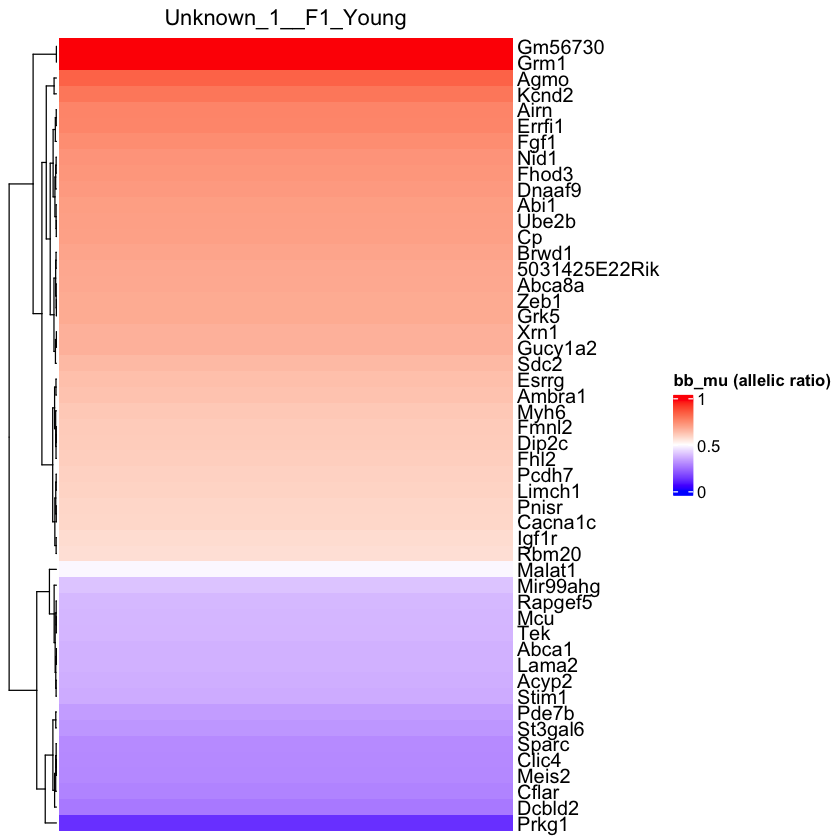

In [22]:
## (2) Per-group top 50 bb_mu heatmaps (ranked by p.adj)
if (!"ComplexHeatmap" %in% loadedNamespaces()) library(ComplexHeatmap)
if (!"circlize" %in% loadedNamespaces())      library(circlize)

if (!length(results_fdr)) {
    message("results_fdr is empty; skipping per-group heatmaps.")
} else {
    col_bb <- circlize::colorRamp2(c(0, 0.5, 1), c("blue", "white", "red"))

    for (i in seq_len(nrow(group_info))) {
        grp_id <- group_info$group_id[i]
        df <- results_fdr[[grp_id]]
        if (is.null(df)) next
        if (is.null(df$gene)) df$gene <- rownames(df)
        if (!all(c("gene","p.adj","bb_mu") %in% colnames(df))) next

        grp_path <- group_info$path[i]

        finite_mask <- is.finite(df$p.adj)
        num_sig <- sum(finite_mask & df$p.adj < 0.05, na.rm = TRUE)
        message(sprintf("%s: %d genes with FDR < 0.05", grp_id, num_sig))

        df_finite <- df[finite_mask, , drop = FALSE]
        if (!nrow(df_finite)) next

        df_finite <- df_finite[order(df_finite$p.adj), ]
        top_n  <- min(50, nrow(df_finite))
        df_top <- df_finite[seq_len(top_n), , drop = FALSE]

        mat <- matrix(df_top$bb_mu, ncol = 1,
                      dimnames = list(df_top$gene, "bb_mu"))
        mat[!is.finite(mat)] <- NA_real_

        ht_ct <- Heatmap(
            mat,
            name = "bb_mu",
            col  = col_bb,
            show_row_names = TRUE,
            show_column_names = FALSE,
            cluster_rows = TRUE,
            cluster_columns = FALSE,
            column_title = grp_id,
            heatmap_legend_param = list(title = "bb_mu (allelic ratio)")
        )

        message("Rendering top genes for " , grp_id)
        draw(ht_ct)

        out_pdf <- file.path(grp_path, sprintf("bb_mean_top50_%s_heatmap.pdf", grp_id))
        dir.create(dirname(out_pdf), showWarnings = FALSE, recursive = TRUE)
        grDevices::pdf(out_pdf, width = 4, height = 10)
        draw(ht_ct)
        grDevices::dev.off()
    }
}


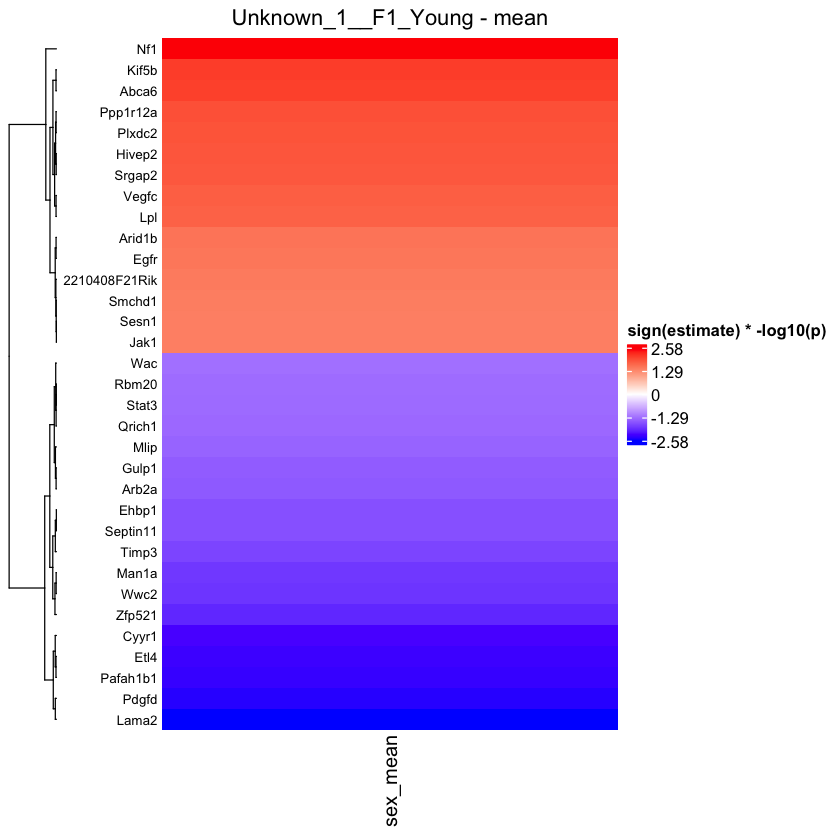

In [29]:
if (!"ComplexHeatmap" %in% loadedNamespaces()) suppressPackageStartupMessages(library(ComplexHeatmap))
if (!"circlize" %in% loadedNamespaces()) suppressPackageStartupMessages(library(circlize))
if (!"grid" %in% loadedNamespaces()) suppressPackageStartupMessages(library(grid))

if (!exists("group_info") || !is.data.frame(group_info) || !nrow(group_info)) {
base_dir <- "../results/celltype_wo_condition"
all_dirs <- list.dirs(base_dir, full.names = TRUE, recursive = TRUE)
has_tbl <- file.exists(file.path(all_dirs, "aspen_sex_coef_by_gene.csv")) |
file.exists(file.path(all_dirs, "glm_coef_by_gene.csv")) |
file.exists(file.path(all_dirs, "group_mean_sex_results.csv")) |
file.exists(file.path(all_dirs, "group_var_sex_results.csv"))
grp_paths <- all_dirs[has_tbl]
group_info <- data.frame(
celltype = basename(dirname(grp_paths)),
condition = basename(grp_paths),
group_id = paste(basename(dirname(grp_paths)), basename(grp_paths), sep = "__"),
path = grp_paths,
stringsAsFactors = FALSE
)
}
if (!exists("group_map") || !length(group_map)) {
group_map <- setNames(group_info$path, group_info$group_id)
}

load_coef_table <- function(grp_id) {
grp_path <- group_map[[grp_id]]
if (is.null(grp_path)) stop(sprintf("Unknown group_id: %s", grp_id))
candidates <- c(
file.path(grp_path, "aspen_sex_coef_by_gene.csv"),
file.path("..", grp_path, "aspen_sex_coef_by_gene.csv"),
file.path(grp_path, "glm_coef_by_gene.csv"),
file.path("..", grp_path, "glm_coef_by_gene.csv")
)
idx <- which(file.exists(candidates))[1]
if (!is.na(idx)) {
df <- read.csv(candidates[idx], stringsAsFactors = FALSE, check.names = FALSE)
} else {
# Fallback: derive from ASPEN group outputs directly
mean_csv <- file.path(grp_path, "group_mean_sex_results.csv")
var_csv <- file.path(grp_path, "group_var_sex_results.csv")
if (!file.exists(mean_csv) && !file.exists(var_csv)) {
stop(sprintf("Coefficient table not found for %s and no group_mean/var CSVs present", grp_id))
}
dfm <- if (file.exists(mean_csv)) read.csv(mean_csv, check.names = FALSE) else NULL
dfv <- if (file.exists(var_csv)) read.csv(var_csv, check.names = FALSE) else NULL
mk <- function(d, term_lab, pcol, llrcol = "llr", estcol = "log2FC") {
if (is.null(d)) return(NULL)
gcol <- if ("gene" %in% names(d)) "gene" else if ("X" %in% names(d)) "X" else NULL
if (is.null(gcol) && !is.null(rownames(d))) { d$gene <- rownames(d); gcol <- "gene" }
z <- suppressWarnings(sign(d[[estcol]]) * sqrt(pmax(d[[llrcol]], 0)))
data.frame(
gene = as.character(d[[gcol]]),
term = term_lab,
estimate = as.numeric(d[[estcol]]),
se = ifelse(is.finite(z) & z != 0, d[[estcol]]/z, NA_real_),
z = z,
p = as.numeric(d[[pcol]]),
stringsAsFactors = FALSE
)
}
df <- rbind(mk(dfm, "sexM", "pval", "llr", "log2FC"),
mk(dfv, "sexM_var", "pval_var", "llr_var", "log2FC"))
df <- df[!is.na(df$gene) & nzchar(df$gene), , drop = FALSE]
}

if (!"gene" %in% names(df)) {
if ("X" %in% names(df)) names(df)[names(df)=="X"] <- "gene"
if ("...1" %in% names(df)) names(df)[names(df)=="...1"] <- "gene"
if ("SYMBOL"%in% names(df)) names(df)[names(df)=="SYMBOL"] <- "gene"
if (!"gene" %in% names(df) && !is.null(rownames(df))) df$gene <- rownames(df)
}
df$gene <- as.character(df$gene)
if ("p" %in% names(df)) df$p <- suppressWarnings(as.numeric(df$p))
if ("estimate" %in% names(df)) df$estimate <- suppressWarnings(as.numeric(df$estimate))
df
}

build_signed_logp_vector <- function(tbl, term_exact, top_genes = 40, alpha = 0.05) {
if (is.null(tbl) || !nrow(tbl)) return(NULL)
keep <- !is.na(tbl$term) & tbl$term == term_exact &
"p" %in% names(tbl) & is.finite(tbl$p) &
"estimate" %in% names(tbl) &
!is.na(tbl$gene) & nzchar(tbl$gene)
sub <- tbl[keep, , drop = FALSE]
if (!nrow(sub)) return(NULL)
sub$score <- sign(sub$estimate) * -log10(pmax(sub$p, .Machine$double.xmin))
sig <- sub[sub$p < alpha, , drop = FALSE]
pick <- if (nrow(sig)) sig else sub
pick <- pick[order(pick$p), , drop = FALSE]
if (nrow(pick) > top_genes) pick <- pick[seq_len(top_genes), , drop = FALSE]
v <- pick$score; names(v) <- as.character(pick$gene)
v
}

plot_sex_dual_heatmap <- function(grp_id, top_genes = 40, show_plot = TRUE, unique_only = TRUE) {
grp_path <- group_map[[grp_id]]
if (is.null(grp_path)) { message("Unknown group: ", grp_id); return(invisible(NULL)) }
tbl <- tryCatch(load_coef_table(grp_id), error = function(e) NULL)
if (is.null(tbl) || !nrow(tbl)) { message("No coefficients for ", grp_id); return(invisible(NULL)) }

v_mean <- build_signed_logp_vector(tbl, "sexM", top_genes = Inf)
v_var <- build_signed_logp_vector(tbl, "sexM_var", top_genes = Inf)

if (!is.null(v_mean) && length(v_mean) > top_genes) v_mean <- v_mean[seq_len(top_genes)]
if (!is.null(v_var)) {
if (isTRUE(unique_only) && !is.null(v_mean)) v_var <- v_var[setdiff(names(v_var), names(v_mean))]
if (length(v_var) > top_genes) v_var <- v_var[seq_len(top_genes)]
}
if ((is.null(v_mean) || !length(v_mean)) && (is.null(v_var) || !length(v_var))) {
message("No entries after filtering for ", grp_id); return(invisible(NULL))
}

cap_of <- function(x) { x <- as.numeric(x); x <- x[is.finite(x)]; if (!length(x)) return(1); max(stats::quantile(abs(x), 0.95, na.rm = TRUE), 1) }
cap_mean <- if (!is.null(v_mean) && length(v_mean)) cap_of(v_mean) else 1
cap_var <- if (!is.null(v_var) && length(v_var)) cap_of(v_var) else 1
col_mean <- circlize::colorRamp2(c(-cap_mean, 0, cap_mean), c("blue","white","red"))
col_var <- circlize::colorRamp2(c(-cap_var, 0, cap_var), c("blue","white","red"))

to_mat <- function(v, label, cap) {
if (is.null(v) || !length(v)) return(NULL)
matrix(pmax(pmin(as.numeric(v), cap), -cap), ncol = 1, dimnames = list(names(v), label))
}
m_mean <- to_mat(v_mean, "sex_mean", cap_mean)
m_var <- to_mat(v_var, "sex_var", cap_var)

maxw <- function(genes) ComplexHeatmap::max_text_width(genes, gp = grid::gpar(fontsize = 8))
rnw_mean <- if (!is.null(m_mean)) maxw(rownames(m_mean)) else grid::unit(0, "cm")
rnw_var <- if (!is.null(m_var)) maxw(rownames(m_var)) else grid::unit(0, "cm")

ht_list <- NULL
if (!is.null(m_mean)) {
ht_mean <- Heatmap(
m_mean, name = "mean_signed_log10p", col = col_mean, na_col = "grey90",
cluster_rows = TRUE, cluster_columns = FALSE,
show_row_names = TRUE, row_names_side = "left",
row_names_gp = grid::gpar(fontsize = 8), row_names_max_width = rnw_mean,
show_column_names = TRUE,
column_title = paste0(grp_id, " - mean"),
heatmap_legend_param = list(title = "sign(estimate) * -log10(p)",
at = round(seq(-cap_mean, cap_mean, length.out = 5), 2))
)
ht_list <- ht_mean
}
if (!is.null(m_var)) {
ht_var <- Heatmap(
m_var, name = "var_signed_log10p", col = col_var, na_col = "grey90",
cluster_rows = TRUE, cluster_columns = FALSE,
show_row_names = TRUE, row_names_side = "right",
row_names_gp = grid::gpar(fontsize = 8), row_names_max_width = rnw_var,
show_column_names = TRUE,
column_title = paste0(grp_id, " - variance"),
heatmap_legend_param = list(title = "sign(estimate) * -log10(p)",
at = round(seq(-cap_var, cap_var, length.out = 5), 2))
)
ht_list <- if (is.null(ht_list)) ht_var else (ht_list + ht_var)
}
if (is.null(ht_list)) { message("Nothing to draw for ", grp_id); return(invisible(NULL)) }

n_rows <- max(if (!is.null(m_mean)) nrow(m_mean) else 0, if (!is.null(m_var)) nrow(m_var) else 0)
pdf_h <- max(4, min(12, n_rows * 0.25 + 2))
pdf_path <- file.path(grp_path, sprintf("glm_coef_signed_logp_heatmap_dual_%s.pdf", grp_id))
grDevices::pdf(pdf_path, width = 12, height = pdf_h) # extra width for row names
draw(ht_list, newpage = TRUE, merge_legend = FALSE)
grDevices::dev.off()
for (ext in c("png", "tiff")) {
out_file <- paste0(tools::file_path_sans_ext(pdf_path), ".", tolower(ext))
dev_fun <- switch(tolower(ext), png = grDevices::png, tiff = grDevices::tiff, jpeg = grDevices::jpeg, jpg = grDevices::jpeg)
dev_fun(out_file, width = 12, height = pdf_h, units = "in", res = 200)
draw(ht_list, newpage = TRUE, merge_legend = FALSE)
grDevices::dev.off()
}
if (isTRUE(show_plot)) draw(ht_list, newpage = TRUE, merge_legend = FALSE)
invisible(pdf_path)
}

cleanup_old_sex_plots <- function() {
pats <- c("glm_coef_signed_logp_heatmap_.sex.\\.(pdf|png|tiff|tif)$",
"glm_coef_signed_logp_heatmap_dual_.*\\.(pdf|png|tiff|tif)$")
old <- list.files("../results/celltype_wo_condition", pattern = paste(pats, collapse="|"),
recursive = TRUE, full.names = TRUE)
if (length(old)) file.remove(old)
}
cleanup_old_sex_plots()

coef_heatmap_dual_outputs <- lapply(group_info$group_id, plot_sex_dual_heatmap, top_genes = 40)
names(coef_heatmap_dual_outputs) <- group_info$group_id

# Barplots for overral allelic imbalance summary

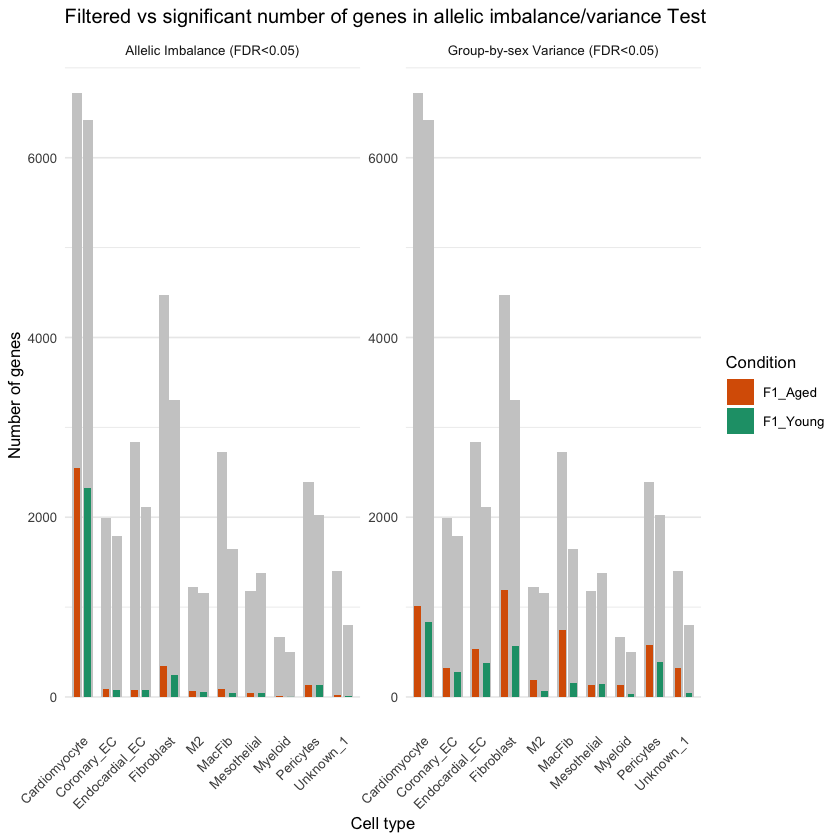

In [31]:

## Summary barplots: filtered vs significant (mean/variance) per celltype and condition
suppressPackageStartupMessages({
  library(dplyr); library(readr); library(tidyr); library(ggplot2); library(stringr)
})

base_dir <- "../results/celltype_wo_condition"
all_dirs <- list.dirs(base_dir, full.names = TRUE, recursive = TRUE)
# groups that have bb_mean_results_norm.csv (defines filtered set)
grp_dirs <- all_dirs[file.exists(file.path(all_dirs, "bb_mean_results_norm.csv"))]
if (!length(grp_dirs)) stop("No groups found with bb_mean_results_norm.csv")

summ <- lapply(grp_dirs, function(d) {
  ct <- basename(dirname(d)); cond <- basename(d); gid <- paste(ct, cond, sep="__")
  # filtered count via bb_mean rows (normalized results)
  bb <- suppressMessages(try(readr::read_csv(file.path(d, "bb_mean_results_norm.csv"), show_col_types = FALSE), silent=TRUE))
  n_filtered <- if (!inherits(bb, "try-error") && !is.null(bb)) nrow(bb) else NA_integer_
  n_sig_bb_mean <- NA_integer_
  if (!inherits(bb, "try-error") && !is.null(bb) && nrow(bb)) {
    p_adj_mean <- suppressWarnings(p.adjust(bb$pval_mean, method = "BH"))
    n_sig_bb_mean <- sum(is.finite(p_adj_mean) & p_adj_mean < 0.05, na.rm = TRUE)
  }
  gv_path <- file.path(d, "group_var_sex_results.csv")
  n_sig_bb_var <- NA_integer_
  if (file.exists(gv_path)) {
    gv <- suppressMessages(readr::read_csv(gv_path, show_col_types = FALSE))
    p <- gv$pval_var
    p_adj <- suppressWarnings(p.adjust(p, method = "BH"))
    n_sig_bb_var <- sum(is.finite(p_adj) & p_adj < 0.05, na.rm = TRUE)
  }
  tibble::tibble(celltype = ct, condition = cond, group_id = gid,
                 filtered = n_filtered, sig_bb_mean = n_sig_bb_mean, sig_bb_var = n_sig_bb_var)
}) %>% dplyr::bind_rows()

# Long format for plotting
long <- summ %>%
  tidyr::pivot_longer(cols = c(sig_bb_mean, sig_bb_var), names_to = "metric", values_to = "value") %>%
  mutate(metric = recode(metric, sig_bb_mean = "Allelic Imbalance (FDR<0.05)", sig_bb_var = "Group-by-sex Variance (FDR<0.05)"))

# Plot: background bars = filtered (grey), overlay = significant (colored by condition)
pos <- position_dodge(width = 0.75)
background <- summ %>% select(celltype, condition, filtered) %>% distinct()

p <- ggplot() +
  geom_col(data = background, aes(x = celltype, y = filtered, group = condition),
           fill = "grey80", color = NA, width = 0.7, position = pos) +
  geom_col(data = long, aes(x = celltype, y = value, fill = condition),
           width = 0.45, position = pos) +
  facet_wrap(~ metric, nrow = 1, scales = "free_y") +
  scale_fill_manual(values = c(F1_Aged = "#d95f02", F1_Young = "#1b9e77")) +
  labs(x = "Cell type", y = "Number of genes", fill = "Condition",
       title = "Filtered vs significant number of genes in allelic imbalance/variance Test") +
  theme_minimal(base_size = 10) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        panel.grid.major.x = element_blank())

out_dir <- file.path(base_dir, "summary")
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
pp <- file.path(out_dir, "genes_filtered_vs_sig_barplots")
ggplot2::ggsave(paste0(pp, ".pdf"), p, width = 12, height = 5)
ggplot2::ggsave(paste0(pp, ".png"), p, width = 12, height = 5, dpi = 200)
print(p)


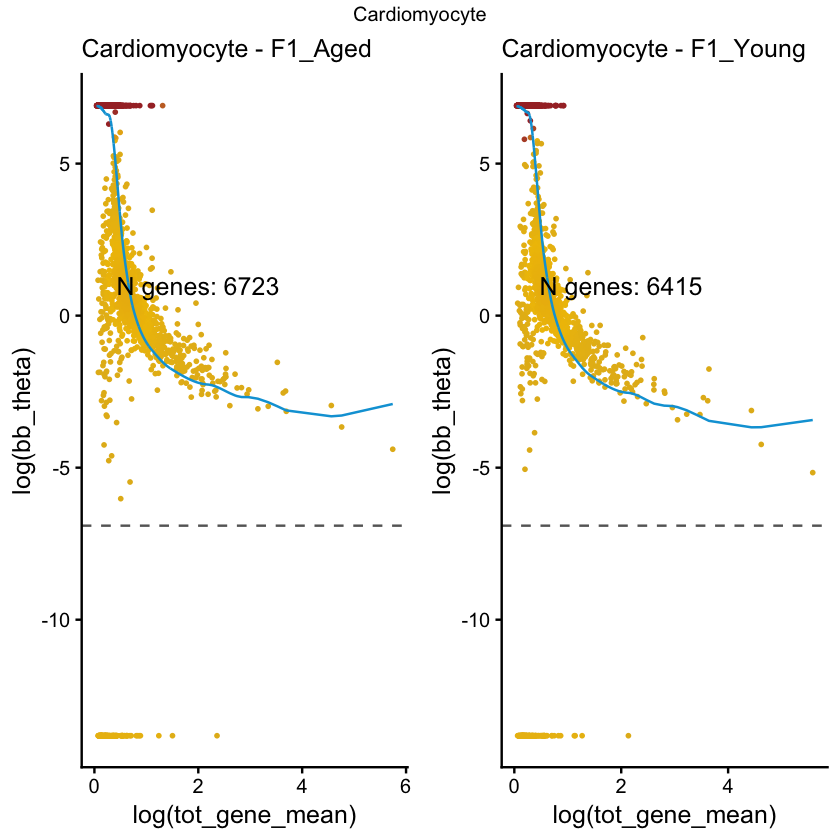

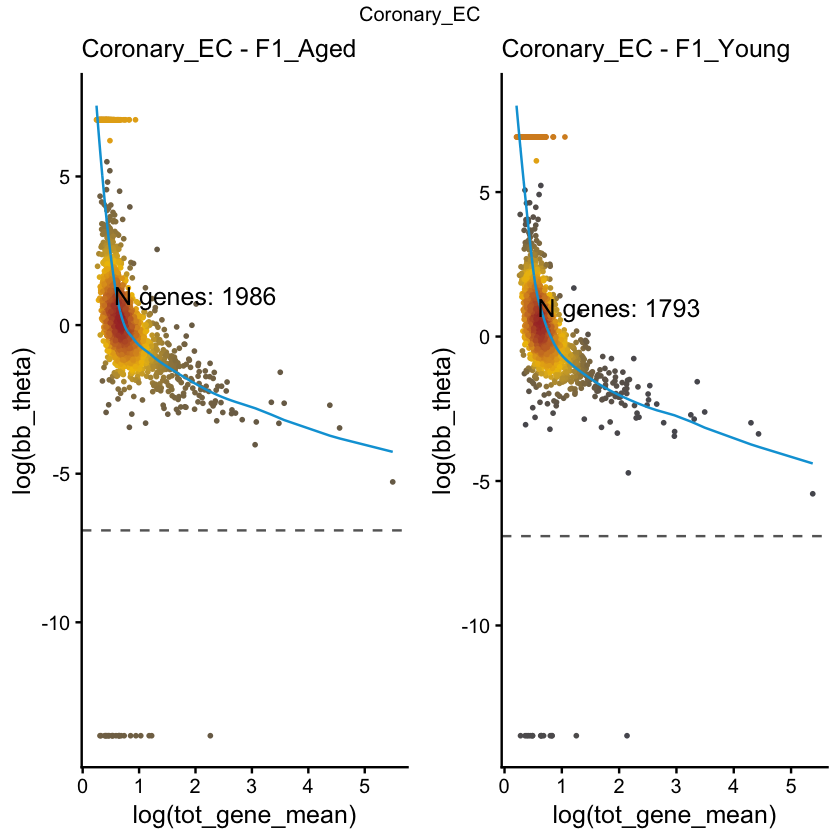

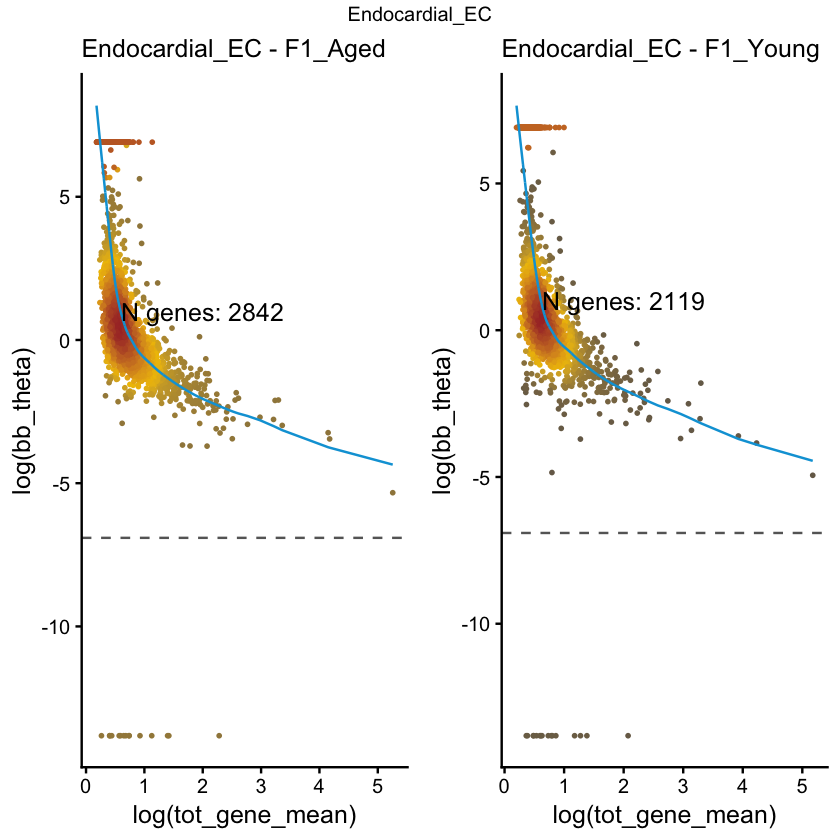

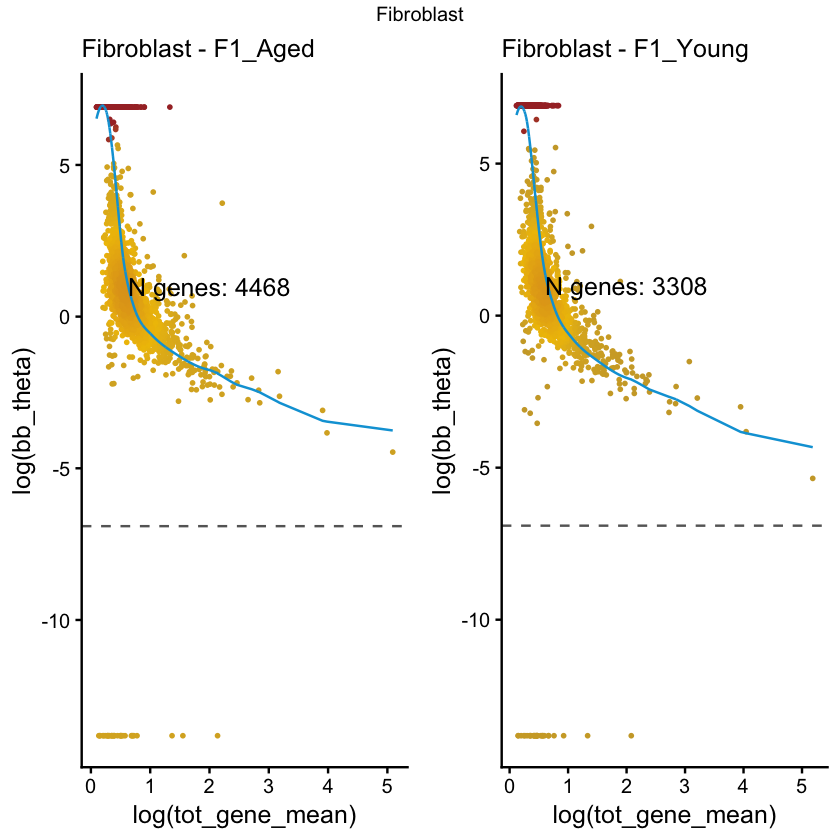

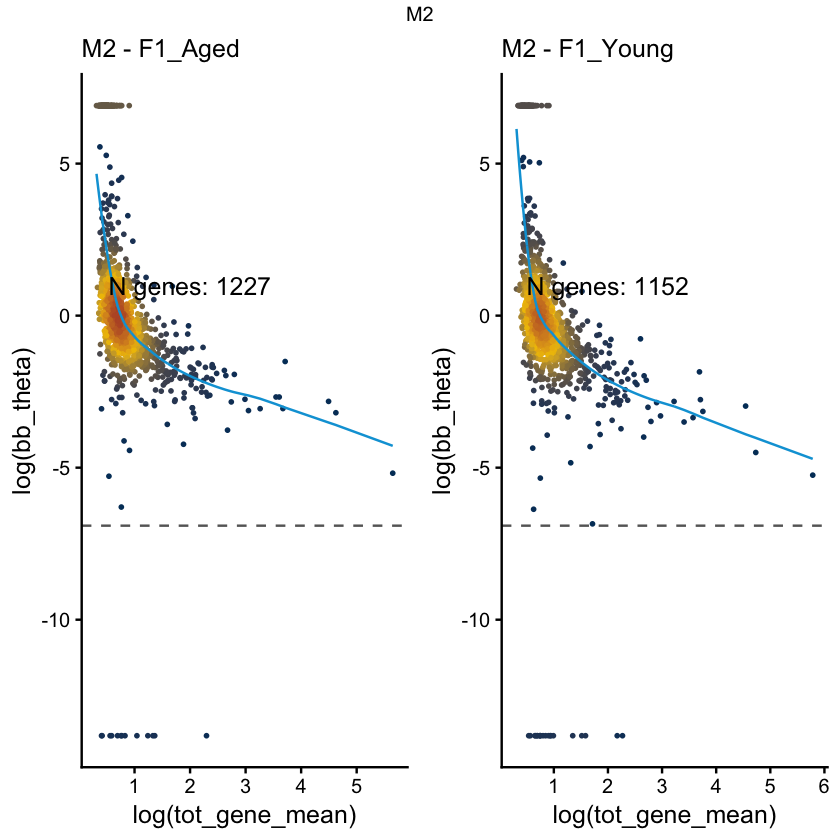

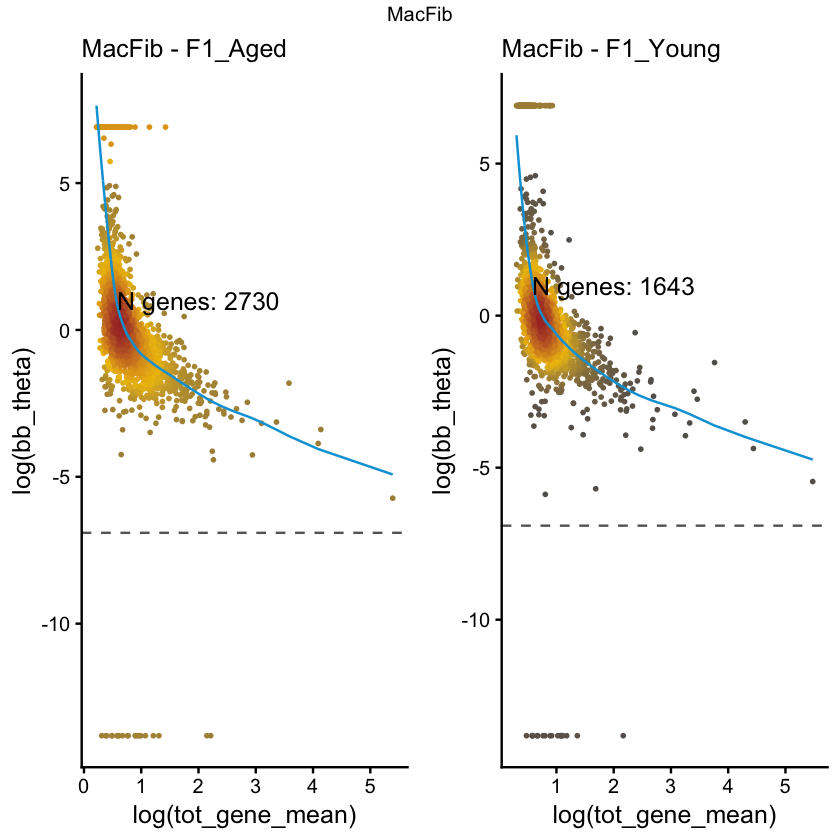

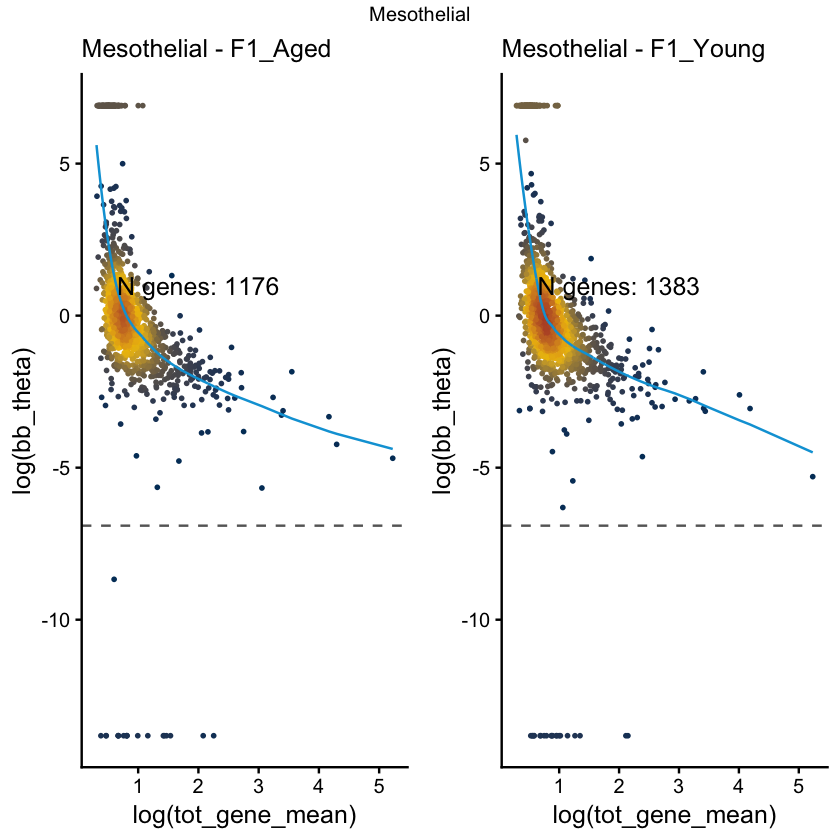

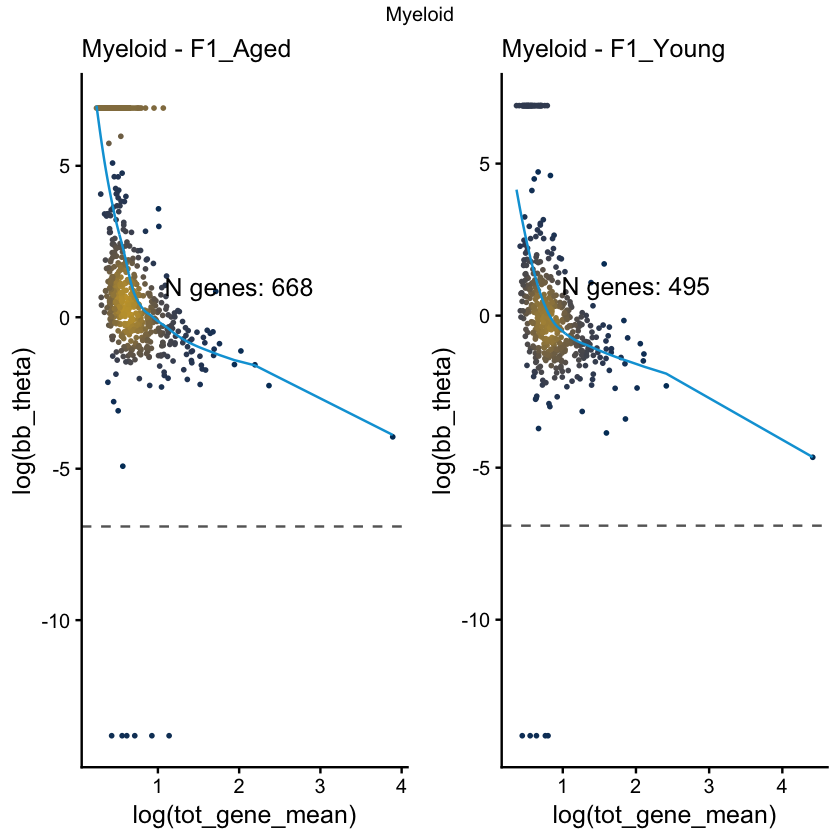

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


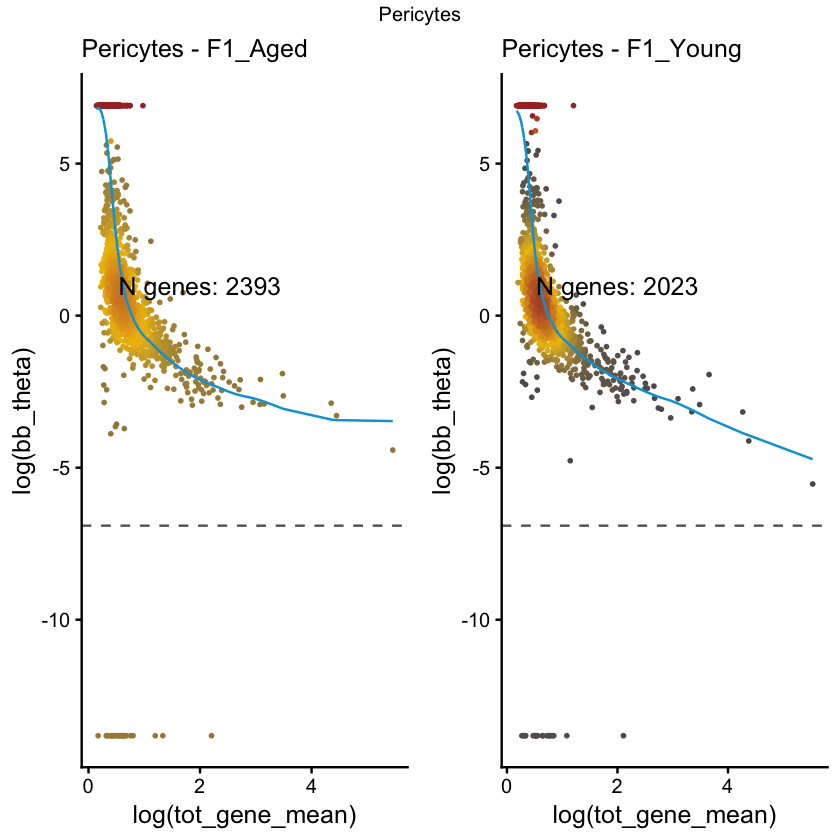

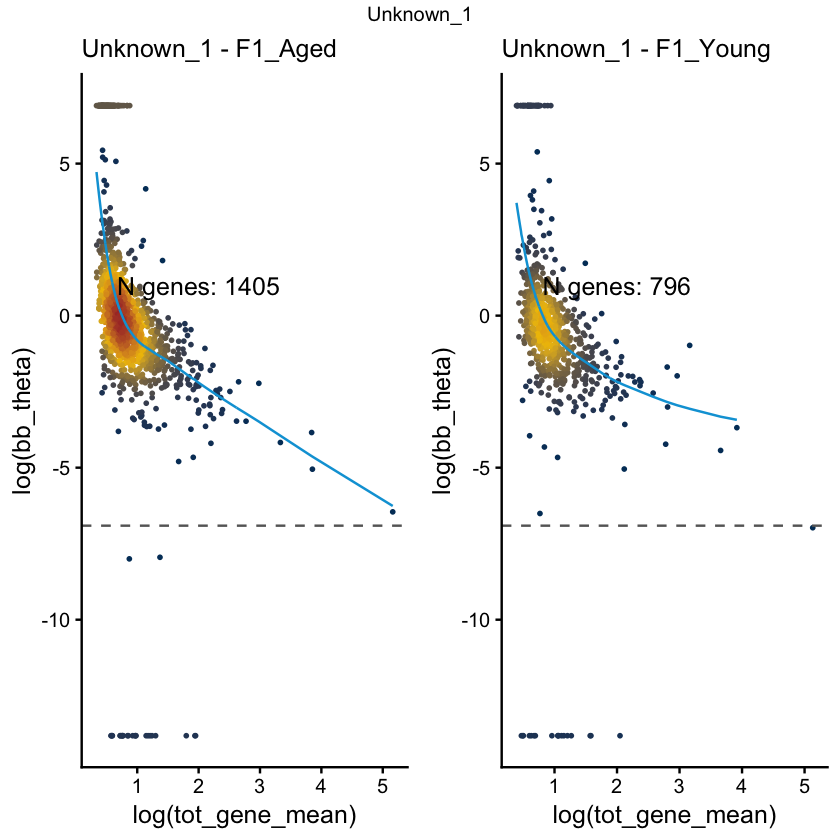

In [34]:
## Dispersion trend snapshots (theta vs depth)
suppressPackageStartupMessages({
  if (!"ASPEN" %in% loadedNamespaces()) {
    rfiles <- list.files("../R", full.names = TRUE, pattern = "\\.R$")
    invisible(lapply(rfiles, source))
  }
  library(gridExtra); library(ggplot2)
})

if (!exists("group_info")) stop("group_info not defined; run earlier cells first")
unique_ct <- unique(group_info$celltype)
if (!length(unique_ct)) stop("No cell types detected in group_info")

for (ct in unique_ct) {
  df_ct <- group_info[group_info$celltype == ct, , drop = FALSE]
  if (!nrow(df_ct)) next
  grobs <- list()
  for (i in seq_len(nrow(df_ct))) {
    grp_path <- df_ct$path[i]
    est_path <- file.path(grp_path, "estimates_global_shrunk.rds")
    if (!file.exists(est_path)) { message("Missing estimates for ", df_ct$group_id[i]); next }
    est <- readRDS(est_path)
    if (!is.data.frame(est) || !nrow(est)) { message("Empty estimates for ", df_ct$group_id[i]); next }
    p <- tryCatch(plot_disp_fit_theta(est, midpoint = 300), error = function(e) NULL)
    if (is.null(p)) { message("plot_disp_fit_theta failed for ", df_ct$group_id[i]); next }
    subtitle_txt <- sprintf("%s - %s", df_ct$celltype[i], df_ct$condition[i])
    p <- p +
      ggplot2::labs(subtitle = subtitle_txt) +
      ggplot2::geom_hline(yintercept = log(1e-03), linetype = "dashed", colour = "grey40")
    grobs[[length(grobs) + 1]] <- p
  }
  if (length(grobs)) {
    title_txt <- sprintf("%s", ct)
    do.call(gridExtra::grid.arrange, c(grobs, ncol = 2, top = title_txt))
  } else {
    message("No dispersion plots generated for ", ct)
  }
}


In [ ]:
## Optional: quick bb_var check with light permutations
suppressPackageStartupMessages({
  if (!"ASPEN" %in% loadedNamespaces()) {
    rfiles <- list.files("../R", full.names = TRUE, pattern = "\\.R$")
    invisible(lapply(rfiles, source))
  }
  library(SingleCellExperiment); library(Matrix); library(dplyr); library(readr); library(VGAM)
})

sce <- readRDS("../data/aspensce_sexupdated_F1_filtered.rds")
meta <- as.data.frame(colData(sce))
ct_col <- intersect(c("celltype_new","celltype","celltype_old"), names(meta))[1]
stopifnot(!is.na(ct_col))
sex_all <- as.character(meta$sex); sex_all[sex_all %in% c("Female","F")] <- "F"; sex_all[sex_all %in% c("Male","M")] <- "M"
cond_all <- meta$condition_new; if (is.null(cond_all)) cond_all <- meta$condition_old
cond_all <- as.character(cond_all); cond_all[is.na(cond_all) | cond_all == ""] <- "NA"

base_dir <- "../results/celltype_wo_condition"
grp_dirs <- list.dirs(base_dir, full.names = TRUE, recursive = TRUE)
grp_dirs <- grp_dirs[file.exists(file.path(grp_dirs, "estimates_global_shrunk.rds"))]
if (!length(grp_dirs)) stop("No groups with estimates_global_shrunk.rds found.")

quick_bb_var <- function(grp_path, n_pmt = 50, n_sim = 100) {
  ct <- basename(dirname(grp_path)); cond <- basename(grp_path); gid <- paste(ct, cond, sep = "__")
  logp <- file.path(grp_path, "filter_log.txt")
  thr <- .parse_thresholds(logp)
  min_counts <- thr$min_counts_test; min_cells <- thr$min_cells_test

  cols <- which(meta[[ct_col]] == ct & cond_all == cond & sex_all %in% c("F","M"))
  if (length(cols) < min_cells) { message("Skipping ", gid, " (too few cells)"); return(NULL) }

  est <- readRDS(file.path(grp_path, "estimates_global_shrunk.rds"))
  a1s <- SummarizedExperiment::assay(sce, "a1")[, cols, drop = FALSE]
  tots<- SummarizedExperiment::assay(sce, "tot")[, cols, drop = FALSE]
  genes <- intersect(rownames(est), rownames(tots))
  if (!length(genes)) { message("No overlap for ", gid); return(NULL) }
  a1 <- as.matrix(a1s[genes, , drop = FALSE]); mode(a1) <- "integer"
  tot<- as.matrix(tots[genes, , drop = FALSE]); mode(tot)<- "integer"

  res_var <- tryCatch(bb_var(a1_counts = a1, tot_counts = tot, estimates = est,
                             min_cells = min_cells, min_counts = min_counts,
                             n_pmt = n_pmt, n_sim = n_sim),
                      error = function(e) { message("bb_var failed for ", gid, ": ", conditionMessage(e)); NULL })
  if (is.null(res_var)) return(NULL)
  if ("pval_disp" %in% colnames(res_var)) {
    res_var$padj_disp <- suppressWarnings(p.adjust(res_var$pval_disp, method = "BH"))
  }
  readr::write_csv(res_var, file.path(grp_path, "bb_var_quick.csv"))
  saveRDS(res_var, file.path(grp_path, "bb_var_quick.rds"))
  sig_cnt <- if ("padj_disp" %in% colnames(res_var)) sum(is.finite(res_var$padj_disp) & res_var$padj_disp < 0.05, na.rm = TRUE) else NA_integer_
  message(gid, ": wrote bb_var_quick.* with ", sig_cnt, " FDR<0.05 genes")
  invisible(res_var)
}

bb_var_quick_results <- lapply(grp_dirs, quick_bb_var)
names(bb_var_quick_results) <- basename(grp_dirs)
